### 1. **Loading and Preparing the Data**

In this section, we load the input image and its corresponding mask. The image is in BGR format, so we convert it to RGB for better visualization. If the image or mask is not found, an error message is displayed.


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift
from skimage.segmentation import slic
from skimage.measure import label, regionprops

### 2. **Preprocessing: Filtering the Image**

We apply two types of filters to the image: a Gaussian blur and a Median blur. These filters are used to reduce noise and smooth the image, which can help improve the performance of segmentation algorithms.

In [10]:
image_path = '/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1298_.jpg'
mask_path = '/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/masks/f_r_1298_.bmp'


image = cv2.imread(image_path)
mask = cv2.imread(mask_path, 0)

if image is None or mask is None:
    print("Error: Image or mask not found!")
    exit()

# Convert image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gaussian_filtered = cv2.GaussianBlur(image_rgb, (15, 15), 0)
median_filtered = cv2.medianBlur(image_rgb, 15)

### 3. **K-Means Clustering for Segmentation**

Next, we apply K-Means clustering to segment the image into 3 clusters based on color. This method groups pixels with similar colors, which can be useful for separating different regions in the image.

In [11]:
kmeans = KMeans(n_clusters=3, n_init=10)
image_flattened = image_rgb.reshape((-1, 3))
kmeans.fit(image_flattened)
kmeans_labels = kmeans.labels_.reshape(image_rgb.shape[:2])

### 4. **Mean Shift Clustering on a Smaller Image**

For better segmentation performance, we apply Mean Shift clustering on a smaller version of the image (128x128). After applying clustering, the result is resized back to the original size for comparison.

In [12]:
small_image = cv2.resize(image_rgb, (128, 128))
small_image_flattened = small_image.reshape((-1, 3))

mean_shift = MeanShift(bandwidth=5)
mean_shift.fit(small_image_flattened)
mean_shift_labels = mean_shift.labels_.reshape((128, 128))

# Resize Mean Shift result back to original size
mean_shift_resized = cv2.resize(mean_shift_labels, (image.shape[1], image.shape[0]),
                                interpolation=cv2.INTER_NEAREST)

### 5. **SLIC Superpixel Segmentation**

In this step, we apply SLIC (Simple Linear Iterative Clustering) to segment the image into smaller, homogeneous regions, known as superpixels. These segments can be useful for further analysis or segmentation.


In [13]:
slic_segments = slic(image_rgb, n_segments=100, compactness=10)

### 6. **Region Growing and Connected Component Analysis**

In this step, we apply region growing on a thresholded version of the grayscale image. We then perform connected component analysis (CCA) to identify and filter regions based on their area.

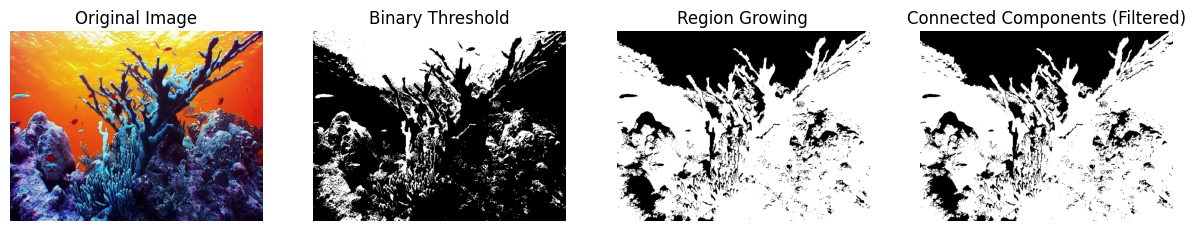

In [14]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 1: Thresholding to create a binary image
_, binary = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY)

# Step 2: Region-Growing Function
def region_growing(image, seed, threshold=5):
    height, width = image.shape
    segmented = np.zeros_like(image)  # Initialize segmentation mask
    stack = [seed]  # Start with the seed point
    seed_value = image[seed]

    while stack:
        x, y = stack.pop()
        if segmented[x, y] == 0 and abs(int(image[x, y]) - int(seed_value)) < threshold:
            segmented[x, y] = 255  # Mark as part of the region
            # Add neighbors to stack
            if x > 0: stack.append((x-1, y))
            if x < height-1: stack.append((x+1, y))
            if y > 0: stack.append((x, y-1))
            if y < width-1: stack.append((x, y+1))

    return segmented

# Choose a seed point manually
seed_point = (100, 100)  # Modify based on object location
region_grown = region_growing(binary, seed_point)

# Step 3: Connected Component Analysis (CCA)
labeled_image = label(region_grown, connectivity=2)
output = np.zeros_like(image)

# Remove small components (noise filtering)
for region in regionprops(labeled_image):
    if region.area > 500:  # Keep regions with a minimum area
        for coord in region.coords:
            output[coord[0], coord[1]] = 255  # Assign to the output mask

# Step 4: Visualization
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(binary, cmap='gray')
ax[1].set_title("Binary Threshold")
ax[1].axis("off")

ax[2].imshow(region_grown, cmap='gray')
ax[2].set_title("Region Growing")
ax[2].axis("off")

ax[3].imshow(output, cmap='gray')
ax[3].set_title("Connected Components (Filtered)")
ax[3].axis("off")

plt.show()

### 7. **Displaying the Comparisons**

We define a function to display comparisons between the original image, the ground truth mask, and the predicted segmentation mask, along with the results of the different filtering and clustering methods.


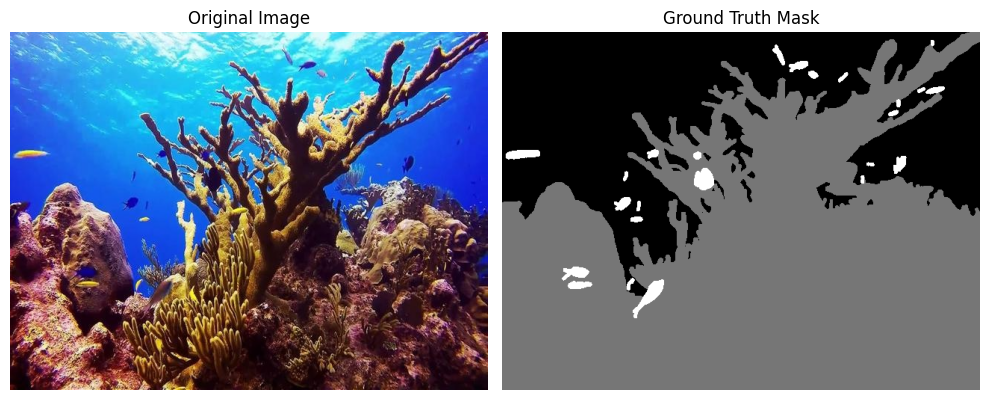

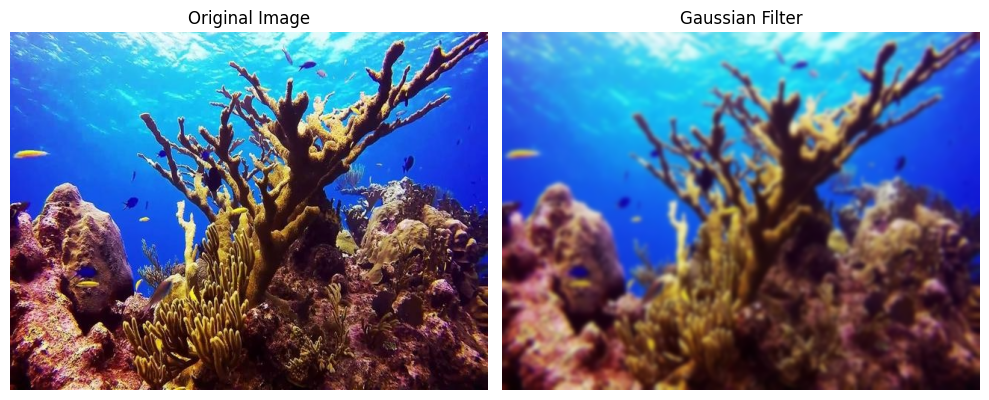

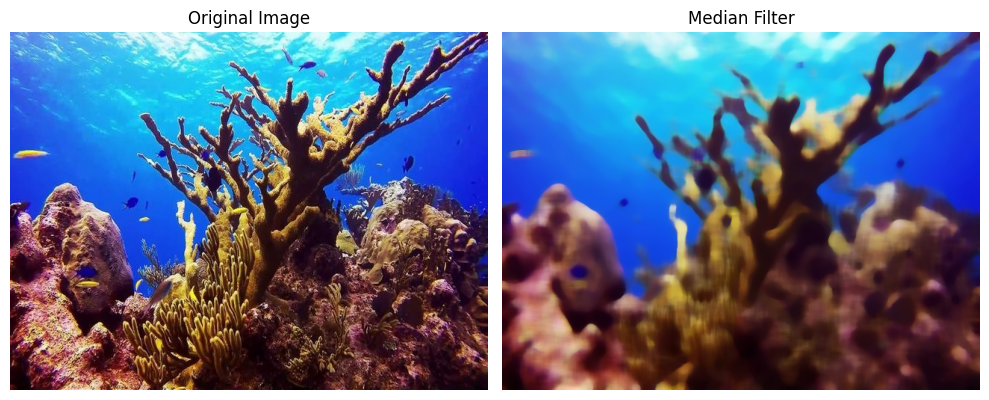

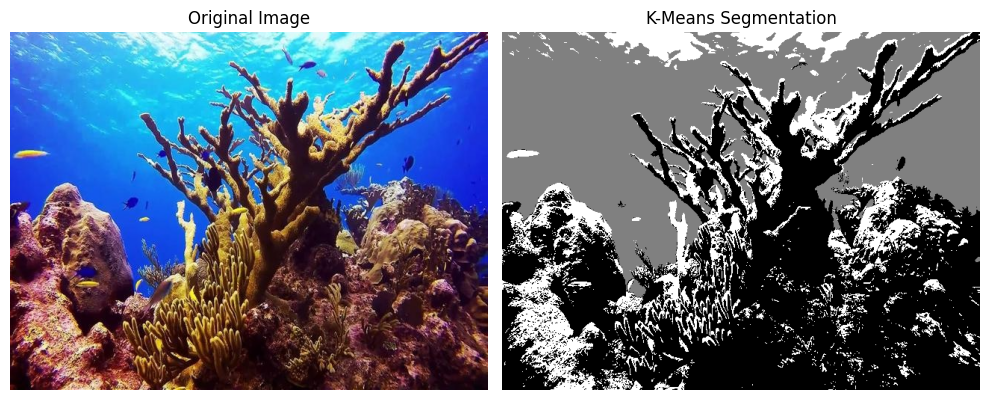

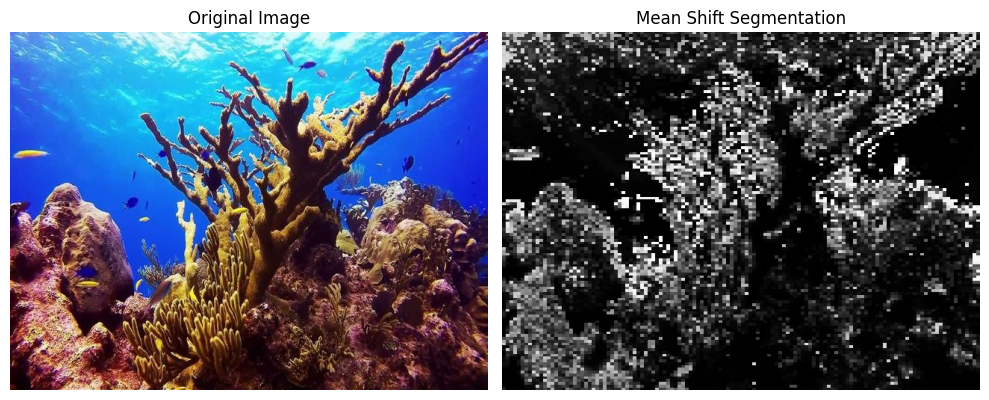

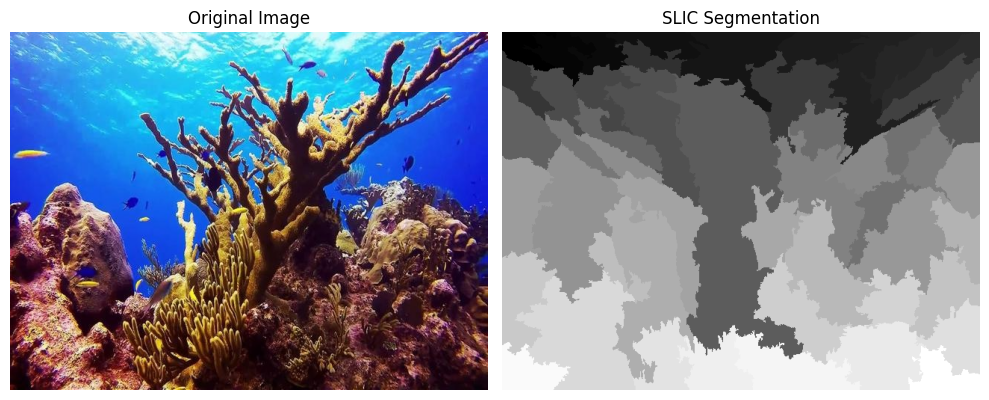

In [15]:
def display_comparison(image, comparison_image, title):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(comparison_image, cmap='gray')
    ax[1].set_title(title)
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

# Display comparisons for each image
display_comparison(image_rgb, mask, "Ground Truth Mask")
display_comparison(image_rgb, gaussian_filtered, "Gaussian Filter")
display_comparison(image_rgb, median_filtered, "Median Filter")
display_comparison(image_rgb, kmeans_labels, "K-Means Segmentation")
display_comparison(image_rgb, mean_shift_resized, "Mean Shift Segmentation")
display_comparison(image_rgb, slic_segments, "SLIC Segmentation")

### 8. **Evaluating the Segmentation Performance**

Finally, we compute evaluation metrics such as Intersection over Union (IoU), Dice Coefficient, and Pixel Accuracy to measure the performance of the segmentation model.

In [16]:
pred_bin = (kmeans_labels > 0).astype(np.uint8)
gt_bin = (mask > 0).astype(np.uint8)

intersection = np.sum((pred_bin == 1) & (gt_bin == 1))
union = np.sum((pred_bin == 1) | (gt_bin == 1))
iou = intersection / union

dice = (2 * intersection) / (np.sum(pred_bin == 1) + np.sum(gt_bin == 1))
accuracy = np.sum(pred_bin == gt_bin) / gt_bin.size

print(f"IoU: {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Pixel Accuracy: {accuracy:.4f}")

IoU: 0.1857
Dice Coefficient: 0.3132
Pixel Accuracy: 0.1860
